# Segmentación mediante KNN

El siguiente código presenta un ejemplo de como realizar la segmentación de imagenes implementado con scikit-image (skimage) y la técnica KNN de sklearn. Este modelo se basa en **clasificar pixeles**, por lo que los datos de entrada serán representaciones de pixeles y las etiquetas corresponden a las clases.

Utiliza imágenes de la base de datos ISIC sobre cáncer de piel con sus respectivas máscaras.

Nota: La ejecución puede tardar un tiempo considerable dependiendo del tamaño de la imagen, principalmente al usar extracción de características.

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.neighbors import KNeighborsClassifier
from functools import partial
from PIL import Image

**Imagen de muestra**

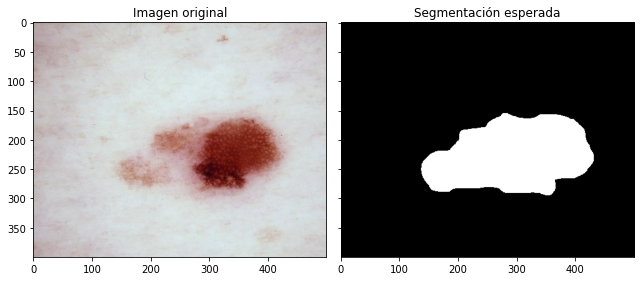

In [24]:
full_img = plt.imread("ISIC_0024313.jpg")
image = Image.open('ISIC_0024313_segmentation.jpg').convert("L")
segmented = np.asarray(image)

segm = segmented[:400, :500]
img = full_img[:400, :500]

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(img)
ax[0].set_title("Imagen original")
ax[1].imshow(segm, cmap='gray')
ax[1].set_title("Segmentación esperada")
fig.tight_layout()

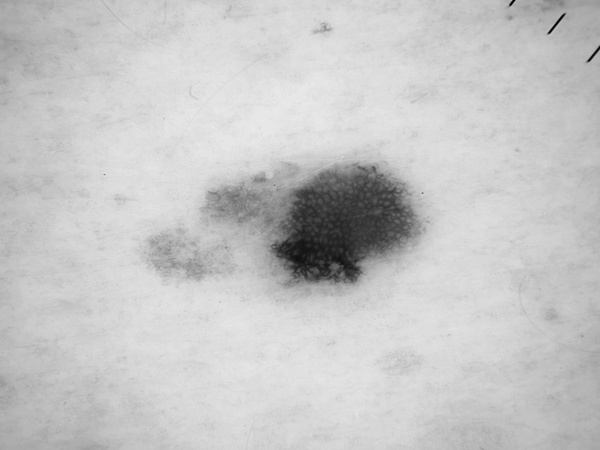

In [25]:
image = Image.open('ISIC_0024313.jpg').convert("L")
image

Se asigna un valor por clase mediante regiones delimitadoras (cuadrados) para etiquetar pixeles de forma que signifique región de interés (posible melanoma) o piel. {1,2} respectivamente

In [26]:
training_labels = np.zeros(img.shape[:2], dtype=np.uint8)
training_labels[0:150 ,0:150] = 1
training_labels[200:250, 250:300] = 2

## Utilizando solo la imagen de prueba

Se instancia un clasificador KNN (con sklearn) y 3 vecinos de hiperparámetro

In [27]:
clf = KNeighborsClassifier(n_neighbors=3)

Entrena con los valores de intensidad de las etiquetas antes asignadas en las regiones de la imagen

In [28]:
clf = future.fit_segmenter(training_labels, img, clf)

Se pedice la etiqueta para todos los pixeles de la imagen. Es decir, para los pixeles de entrenamiento y los de prueba (los que se incluyen en las regiones y los que no)

In [29]:
result = future.predict_segmenter(img, clf)

Se muestran los resultados

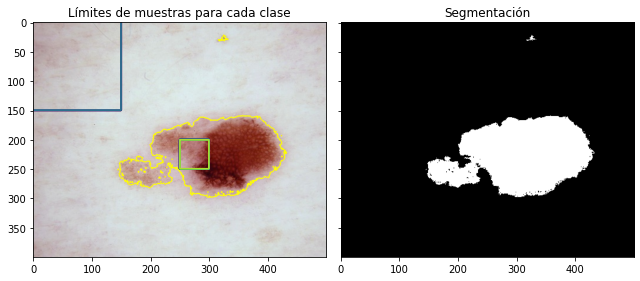

In [30]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Límites de muestras para cada clase')
ax[1].imshow(result, cmap='gray')
ax[1].set_title('Segmentación')
fig.tight_layout()

Se calcula métrica Intersección sobre Unión (IoU) o Índice de Jaccard contra la máscara de segmentación esperada para saber qué porcentaje de la segmentación es correcta

In [31]:
def calculaIoU(gtMask, predMask):
        # Calcula verdaderos positivos, falsos positivos, and falsos negativos
        tp = 0
        fp = 0
        fn = 0
        for i in range(len(gtMask)):
            for j in range(len(gtMask[0])):
                if gtMask[i][j] == 1 and predMask[i][j] == 2:
                    tp += 1
                elif gtMask[i][j] == 0 and predMask[i][j] == 2:
                    fp += 1
                elif gtMask[i][j] == 1 and predMask[i][j] == 1:
                    fn += 1

        # Calcula IoU
        iou = tp / (tp + fp + fn)

        return iou

In [32]:
print("El porcentaje de segmentación correcta es: {}%".format(round(1-calculaIoU(segm, result),4)*100))

El porcentaje de segmentación correcta es: 91.67%


## Utilizando extracción de características

El siguiente código sirve para aplicar un banco de filtros y transformaciones a la imagen para extraer características de la región de interés manejadas en forma de vector.

In [18]:
sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
features = features_func(img)

Se define un clasificador KNN

In [19]:
clf_ec = KNeighborsClassifier(n_neighbors=3)

Entrena con las etiquetas de la mascara antes realizada y las caracteristicas

In [20]:
clf_ec = future.fit_segmenter(training_labels, features, clf_ec)

Se pedice la etiqueta para todos los pixeles de la imagen (es decir, para los pixeles de entrenamiento y los de prueba)

In [21]:
result = future.predict_segmenter(features, clf_ec)

Se muestran los resultados

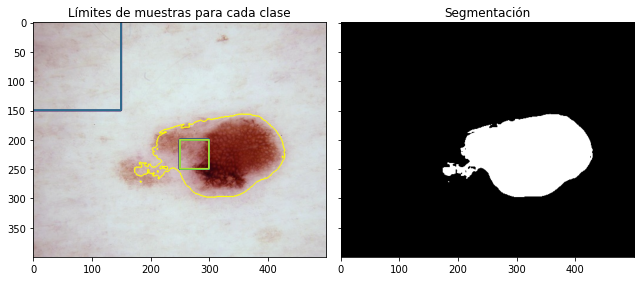

In [22]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Límites de muestras para cada clase')
ax[1].imshow(result, cmap='gray')
ax[1].set_title('Segmentación')
fig.tight_layout()

In [33]:
print("El porcentaje de segmentación correcta es: {}%".format(round(1-calculaIoU(segm, result),4)*100))

El porcentaje de segmentación correcta es: 91.67%


# Ejercicio. Divida todos los datos proporcionados (imágenes de melanoma) en conjuntos de entrenamiento y prueba. Replique el ejercicio de muestra con esos datos, es decir, implemente un clasificador KNN utilizando todas las imágenes en conjunto, recordando que la clasificación es por pixel. Pruebe diferentes valores para el hiperparamétro, explore la función para extraer características y varíe las coordenadas y tamaños de cuadros delimitadores para alguna imagen individual.

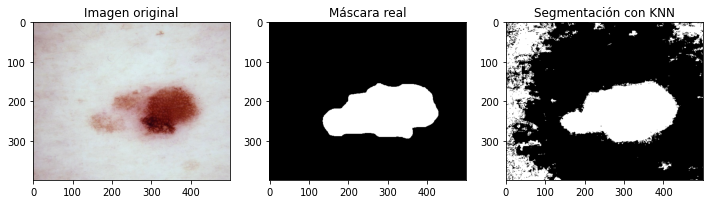

In [ ]:


def cargar_y_recortar(ruta_imagen, ruta_mascara, tamano_recorte=(400, 500)):
    imagen_completa = plt.imread(ruta_imagen)
    imagen_mascara = Image.open(ruta_mascara).convert("L")
    mascara_segmentada = np.asarray(imagen_mascara)

    imagen_recortada = imagen_completa[:tamano_recorte[0], :tamano_recorte[1]]
    mascara_recortada = mascara_segmentada[:tamano_recorte[0], :tamano_recorte[1]]

    return imagen_recortada, mascara_recortada

imagenes_entrenamiento = ["ISIC_0024351.jpg", "ISIC_0024481.jpg", "ISIC_0024496.jpg"]
mascaras_entrenamiento = ["ISIC_0024351_segmentation.jpg", "ISIC_0024481_segmentation.jpg", "ISIC_0024496_segmentation.jpg"]

imagenes, mascaras = [], []
for ruta_imagen, ruta_mascara in zip(imagenes_entrenamiento, mascaras_entrenamiento):
    imagen, mascara = cargar_y_recortar(ruta_imagen, ruta_mascara)
    imagenes.append(imagen)
    mascaras.append(mascara)

def extraer_caracteristicas_etiquetas(imagen, mascara):
    alto, ancho, canales = imagen.shape
    caracteristicas = imagen.reshape(-1, canales)
    etiquetas = mascara.reshape(-1) > 0
    return caracteristicas, etiquetas.astype(int)

lista_caracteristicas, lista_etiquetas = [], []
for imagen, mascara in zip(imagenes, mascaras):
    X, y = extraer_caracteristicas_etiquetas(imagen, mascara)
    lista_caracteristicas.append(X)
    lista_etiquetas.append(y)

caracteristicas_entrenamiento = np.vstack(lista_caracteristicas)
etiquetas_entrenamiento = np.hstack(lista_etiquetas)

modelo_knn = KNeighborsClassifier(n_neighbors=3)
modelo_knn.fit(caracteristicas_entrenamiento, etiquetas_entrenamiento)

imagen_prueba, mascara_prueba = cargar_y_recortar("ISIC_0024313.jpg", "ISIC_0024313_segmentation.jpg")

alto, ancho, canales = imagen_prueba.shape
caracteristicas_prueba = imagen_prueba.reshape(-1, canales)
etiquetas_predichas = modelo_knn.predict(caracteristicas_prueba)
segmentacion_predicha = etiquetas_predichas.reshape(alto, ancho)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(imagen_prueba)
ax[0].set_title("Imagen original")
ax[1].imshow(mascara_prueba, cmap="gray")
ax[1].set_title("Máscara real")
ax[2].imshow(segmentacion_predicha, cmap="gray")
ax[2].set_title("Segmentación con KNN")
plt.show()
